**Input**
- PLINK2 GWAS summary statistics
- MAGMA gene analysis results

**Source**
- From Pan-UKBB summary statistics
- From my own GWAS

Both are based on the same data, and therefore must yield the same result

**Phenotype**  
1180 Morning/evening person (chronotype)

**Population**
- Pan-UKBB: EUR (European)
- My own GWAS: White-British

**Process: calculate the following**
- PLINK2
  - Scatter plot of SNP-wise comparison (between Pan-UKBB and my own GWAS)
    - All SNPs
    - Statistically significant SNPs
- MAGMA
  - Adding info
    - Bonferroni-corrected P-values (also written P-Bonf)
    - q-values (also known as FDR-adjusted p-values)
    - Annotation of whether those values are under FDR threshold
  - Scatter plot of SNP-wise comparison (between Pan-UKBB and my own GWAS)
    - All SNPs
    - Statistically significant SNPs

# Preparation (Execute all in this section!)

## Import libraries & set environment variables

In [1]:
import collections
from datetime import datetime
import os
import numpy as np
from pathlib import Path
import polars as pl
import re
import textwrap

import warnings
# suppress DeprecationWarning messages
warnings.filterwarnings("ignore", category=DeprecationWarning)

from matplotlib import pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3

dir_home = Path(os.getcwd()).parent.parent.parent
os.chdir(dir_home)
print("Current directory (check that it's your home directory):", os.getcwd())

ModuleNotFoundError: No module named 'polars'

## File I/O

In [10]:
# Input: Pan-UKBB summary statistics
FILE_SUMSTAT_PANUKBB_CHRONOTYPE = os.path.join("data", 
                                    "panukbb",
                                    "for_magma",
                                    "per_phenotype",
                                    "continuous-1180-both_sexes.tsv"
                                   )
# Input: MAGMA result from Pan-UKBB
FILE_MAGMA_PANUKBB_CHRONOTYPE = os.path.join("analysis", "specific", 
                       "analysis_20230529_01_gwas",
                       "summary", "1180_comparison_MyGWAS_PanUKBB", 
                       "out.with_p_correction_PanUKBB.csv")

# Input: Pan-UKBB summary statistics
FILE_SUMSTAT_PANUKBB_BMI = os.path.join("data", 
                                    "panukbb",
                                    "for_magma",
                                    "per_phenotype",
                                    "continuous-21001-both_sexes-irnt.tsv"
                                   )


# Input: my old results
DIR_MYGWAS_OLD_9M = os.path.join("analysis", "specific", 
                                       "analysis_20230526_01_gwas",
                                       "00901_1180-0.0")
DIR_MYGWAS_OLD_28M = os.path.join("analysis", "specific", 
                                       "analysis_20230529_01_gwas",
                                       "00901_1180-0.0")
FILE_SUMSTAT_MYGWAS_OLD_9M = os.path.join(
    DIR_MYGWAS_OLD_9M, "pval_for_magma.txt")
FILE_ANNOTATED_MYGWAS_OLD_9M = os.path.join(
    DIR_MYGWAS_OLD_9M, "magma", "with_p_correction.csv")
FILE_SUMSTAT_MYGWAS_OLD_28M = os.path.join(
    DIR_MYGWAS_OLD_28M, "pval_for_magma.txt")
FILE_ANNOTATED_MYGWAS_OLD_28M = os.path.join(
    DIR_MYGWAS_OLD_28M, "magma", "with_p_correction.csv")

# Input + output: my current results - four-way
DIR_MYGWAS_CURRENT = os.path.join("analysis", "specific", 
                                       "analysis_20230605_01_gwas",)
DIR_MYGWAS_NEW_FOURWAY = os.path.join(DIR_MYGWAS_CURRENT, "1180-0.0_Chronotype_fourway_small")
FILE_SUMSTAT_MYGWAS_NEW_FOURWAY = os.path.join(
    DIR_MYGWAS_NEW_FOURWAY, "pval_for_magma.txt")
FILE_ANNOTATED_MYGWAS_NEW_FOURWAY = os.path.join(
    DIR_MYGWAS_NEW_FOURWAY, "magma", "with_p_correction.csv")

# Input + output: my current results - two-way
DIR_MYGWAS_NEW_TWOWAY = os.path.join(DIR_MYGWAS_CURRENT, "1180-0.0_Chronotype_twoway_small")
FILE_SUMSTAT_MYGWAS_NEW_TWOWAY = os.path.join(
    DIR_MYGWAS_NEW_TWOWAY, "pval_for_magma.txt")
FILE_ANNOTATED_MYGWAS_NEW_TWOWAY = os.path.join(
    DIR_MYGWAS_NEW_TWOWAY, "magma", "with_p_correction.csv")

# Input + output: my current results - definite
DIR_MYGWAS_NEW_DEFINITE = os.path.join(DIR_MYGWAS_CURRENT, "1180-0.0_Chronotype_definite_small")
FILE_SUMSTAT_MYGWAS_NEW_DEFINITE = os.path.join(
    DIR_MYGWAS_NEW_DEFINITE, "pval_for_magma.txt")
FILE_ANNOTATED_MYGWAS_NEW_DEFINITE = os.path.join(
    DIR_MYGWAS_NEW_DEFINITE, "magma", "with_p_correction.csv")

# Input + output: my current results - BMI
DIR_MYGWAS_NEW_BMI = os.path.join(DIR_MYGWAS_CURRENT, "21001-0.0_BMI_small")
FILE_SUMSTAT_MYGWAS_NEW_BMI = os.path.join(
    DIR_MYGWAS_NEW_BMI, "pval_for_magma.txt")
FILE_ANNOTATED_MYGWAS_NEW_BMI = os.path.join(
    DIR_MYGWAS_NEW_BMI, "magma", "with_p_correction.csv")

# Output folder
DIR_OUT = os.path.join(DIR_MYGWAS_CURRENT, "summary")
if not os.path.exists(DIR_OUT):
    os.makedirs(DIR_OUT)

# Intermediate output: added info
#     (q-values and statistically significant genes)
FILE_ANNOTATED_PANUKBB = os.path.join(DIR_OUT, "out.with_p_correction_PanUKBB.csv")
FILE_ANNOTATED_MYGWAS = os.path.join(DIR_OUT, "out.with_p_correction_myGWAS.csv")

FDR_THRESHOLD = 0.05 # Q value threshold

## Functions

In [8]:
def flatten(l):
    for el in l:
        if isinstance(el, collections.abc.Iterable) and not isinstance(el, (str, bytes)):
            yield from flatten(el)
        else:
            yield el


def func_print(i):
    if i < 10 or str(i)[1:].count('0') == len(str(i))-1:
        now = datetime.now()
        print(f"{now.strftime('%Y-%m-%d %H:%M:%S')}: {i}")
        

def func_process(FILE_SOURCE, FILE_OUTPUT):
    print("Processing:", FILE_SOURCE)
    # Read as String to avoid any automatic conversion
    df = (pl.read_csv(FILE_SOURCE, 
                      separator=",", 
                      infer_schema_length=0)
          .drop_nulls()
          .with_columns(pl.col("P").cast(pl.Float32).alias("P_Bonf"))
          .with_columns(pl.col("P").cast(pl.Float32).alias("P_log10"))
          .with_columns(pl.col("P").cast(pl.Float32).alias("Q"))
          .with_columns(np.log10(pl.col("P_log10")))
          .sort(by='Q'))

    n_count = df['Q'].is_not_null().sum()

    df = (df
          # Calculate Bonferroni-corrected P values
          .with_columns(pl.col('P_Bonf') * n_count)
           # create a new column which is true if "P_Bonf" is under threshold
          .with_columns((pl.col("P_Bonf") < FDR_THRESHOLD).alias("Positive_P_Bonf"))
          # Calculate Q values
          # Multiply Q column by number of non-null values
          .with_columns(pl.col('Q') * n_count)
          # # Divide the Q columns by the rank of individual value among all the non-null values
          .with_columns(pl.col('Q') / df['Q'].rank())
          # create a new column which is true if "q" is under threshold
          .with_columns((pl.col("Q") < FDR_THRESHOLD).alias("Positive_Q"))
          # Add log10 values
          .with_columns(pl.col("P_Bonf").alias("P_Bonf_log10"))
          .with_columns(np.log10(pl.col("P_Bonf_log10")))
          .with_columns(pl.col("Q").alias("Q_log10"))
          .with_columns(np.log10(pl.col("Q_log10")))
          # Sort
          .sort(by='Positive_P_Bonf', descending=True)
         )
    df.write_csv(FILE_OUTPUT)
    
    
def func_list_genes(FILE_SOURCE, col_gene="Gene"):
    df_all = pl.read_csv(FILE_SOURCE, separator=",")
    df_positive = df_all.filter(pl.col("Positive_P_Bonf"))
    set_genes_all = set(df_all[col_gene])
    set_genes_positive = set(df_positive[col_gene])
    print("All =", len(set_genes_all), "genes, positive =", len(set_genes_positive), "genes")
    return set_genes_all, set_genes_positive


def polars_read(FILE, rename_col):
    print(datetime.now(), "Loading", FILE)
    df = (pl.read_csv(FILE, 
                      separator=" ", 
                      infer_schema_length=0)
          .with_columns(pl.col("P").cast(pl.Float64))
          .rename({"P": rename_col})
         )
    print(df.head)
    return df
    

# Draw p-value scatter plot
def func_compare_pval(df_1, df_2, col_common,
                      graph_title,
                      col1, col2, label1, label2, is_log, plot_unit): 
    df_sumstat_comparison = df_1.join(df_2, on=col_common, how="inner").drop_nulls()
    
    # Scatter plot
    fig, ax = plt.subplots(figsize=[5, 5])
    x = df_sumstat_comparison[col1].to_numpy()
    y = df_sumstat_comparison[col2].to_numpy()
    if not is_log:
        x = np.log10(x)
        y = np.log10(y)

    print("Corr =", np.corrcoef(x, y)[0, 1])

    ax.scatter(x, y, s=2)
    line1, = ax.plot(np.linspace(-30, 0, 10), np.linspace(-30, 0, 10),
                    linestyle="dashed", color = "crimson", alpha = 0.5,)

    ax.set_xlim(-plot_unit * 3, 0)
    ax.set_ylim(-plot_unit * 3, 0)
    ax.set_xticks([-plot_unit * 3, -plot_unit * 2, -plot_unit, 0]) 
    ax.set_yticks([-plot_unit * 3, -plot_unit * 2, -plot_unit, 0]) 

    ax.set_xlabel(label1, fontsize=20)
    ax.set_ylabel(label2, fontsize=20)
    ax.set_title(graph_title, fontsize=24)
    plt.show()
    
    data1 = df_1[col1].to_numpy()
    data2 = df_2[col2].to_numpy()
    if not is_log:
        data1 = np.log10(data1)
        data2 = np.log10(data2)

    # Histogram for each
    fig, ax = plt.subplots(figsize=[5, 5])
    ax.set_xlabel(graph_title, fontsize=22)
    ax.set_ylabel("Count", fontsize=24)
    ax.set_yscale('log')
    ax.hist(data2, # different from y: the whole data
            alpha=0.5, label=label2, density=False, bins=100, color="green")
    ax.hist(data1, # different from x: the whole data
            alpha=1, label=label1, density=False, bins=100, color='#f48d63')
    ax.legend(fontsize=20)

    plt.show()
    
# Draw Venn diagrams - 2 sets
def func_venn2(set_genes_1, set_genes_2, list_names):
    plt.rcParams["figure.figsize"] = [3.5, 3.5]
    plt.rcParams["figure.autolayout"] = True

    out = venn2(
        [set_genes_1, set_genes_2], 
          list_names
               )
    
    for text in out.set_labels:
        text.set_fontsize(14)
    try: # Sometimes it fails because no intersect exists
        for text in out.subset_labels:
            text.set_fontsize(12)
    except:
        pass
    plt.show()

# Process summary statistics

## Read files

### Chronotype

In [24]:
df_sumstat_mygwas_old_9m = polars_read(FILE_SUMSTAT_MYGWAS_OLD_9M, "P_MyGWAS_OLD_9M")
df_sumstat_mygwas_old_28m = polars_read(FILE_SUMSTAT_MYGWAS_OLD_28M, "P_MyGWAS_OLD_28M")
df_sumstat_mygwas_new_fourway = polars_read(FILE_SUMSTAT_MYGWAS_NEW_FOURWAY, "P_MyGWAS_NEW_FOURWAY")

# Input + output: my current results - two-way
DIR_MYGWAS_NEW_TWOWAY = os.path.join(DIR_MYGWAS_CURRENT, "1180-0.0_Chronotype_twoway_small_taihi")
FILE_SUMSTAT_MYGWAS_NEW_TWOWAY = os.path.join(
    DIR_MYGWAS_NEW_TWOWAY, "pval_for_magma.txt")
FILE_ANNOTATED_MYGWAS_NEW_TWOWAY = os.path.join(
    DIR_MYGWAS_NEW_TWOWAY, "magma", "with_p_correction.csv")

df_sumstat_mygwas_new_twoway = polars_read(FILE_SUMSTAT_MYGWAS_NEW_TWOWAY, "P_MyGWAS_NEW_TWOWAY")
df_sumstat_mygwas_new_definite = polars_read(FILE_SUMSTAT_MYGWAS_NEW_DEFINITE, "P_MyGWAS_NEW_DEFINITE")
df_sumstat_panukbb = polars_read(FILE_SUMSTAT_PANUKBB_CHRONOTYPE, "P_PanUKBB")

2023-06-10 14:46:51.059996 Loading analysis\specific\analysis_20230526_01_gwas\00901_1180-0.0\pval_for_magma.txt
<bound method DataFrame.head of shape: (9_437_885, 2)
┌─────────────────────┬─────────────────┐
│ SNP                 ┆ P_MyGWAS_OLD_9M │
│ ---                 ┆ ---             │
│ str                 ┆ f64             │
╞═════════════════════╪═════════════════╡
│ 1:182573227[b37]T,C ┆ 3.4122e-17      │
│ 1:182569626[b37]T,C ┆ 4.0844e-17      │
│ 1:182553693[b37]C,T ┆ 5.3722e-17      │
│ 1:182558139[b37]G,T ┆ 5.5576e-17      │
│ …                   ┆ …               │
│ 2:119972020[b37]G,A ┆ 0.999999        │
│ 7:7454163[b37]G,A   ┆ 0.999999        │
│ 20:12120803[b37]G,C ┆ 1.0             │
│ 6:145457335[b37]A,G ┆ 1.0             │
└─────────────────────┴─────────────────┘>
2023-06-10 14:47:12.470105 Loading analysis\specific\analysis_20230529_01_gwas\00901_1180-0.0\pval_for_magma.txt
<bound method DataFrame.head of shape: (28_037_468, 2)
┌─────────────────────┬───────────

### BMI

In [20]:
df_sumstat_mygwas_new_bmi = polars_read(FILE_SUMSTAT_MYGWAS_NEW_BMI, "P_MyGWAS_NEW_BMI")
df_sumstat_panukbb_bmi = polars_read(FILE_SUMSTAT_PANUKBB_BMI, "P_PanUKBB_BMI")

2023-06-10 14:37:15.210499 Loading analysis\specific\analysis_20230605_01_gwas\21001-0.0_BMI_small\pval_for_magma.txt
<bound method DataFrame.head of shape: (9_437_885, 2)
┌─────────────────────┬──────────────────┐
│ SNP                 ┆ P_MyGWAS_NEW_BMI │
│ ---                 ┆ ---              │
│ str                 ┆ f64              │
╞═════════════════════╪══════════════════╡
│ 16:53802494[b37]C,T ┆ 2.1983e-233      │
│ 16:53800954[b37]T,C ┆ 2.2986e-233      │
│ 16:53803223[b37]G,A ┆ 4.0973e-233      │
│ 16:53803574[b37]T,A ┆ 4.3914e-233      │
│ …                   ┆ …                │
│ 17:58210567[b37]A,C ┆ 1.0              │
│ 19:30006300[b37]A,G ┆ 1.0              │
│ 11:57773306[b37]T,C ┆ 1.0              │
│ 15:92028742[b37]C,T ┆ 1.0              │
└─────────────────────┴──────────────────┘>
2023-06-10 14:37:36.456277 Loading data\panukbb\for_magma\per_phenotype\continuous-21001-both_sexes-irnt.tsv
<bound method DataFrame.head of shape: (28_987_534, 2)
┌─────────────────

## Compare P-values

### Chronotype

Corr = 0.6086882861287474


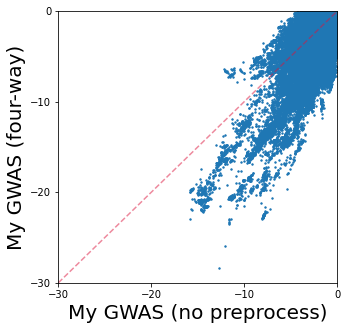

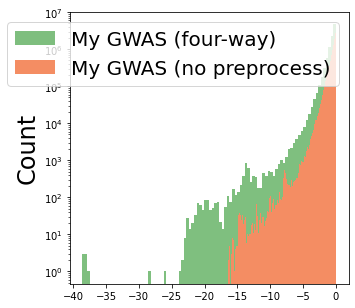

Corr = 0.5508985530068826


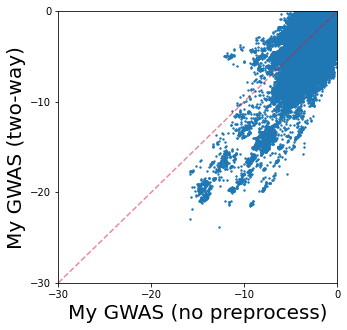

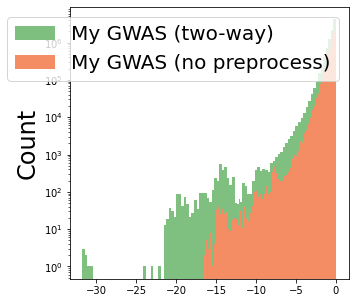

Corr = 0.4875037697909012


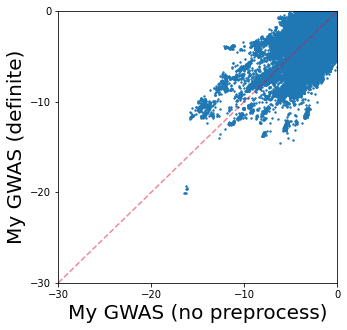

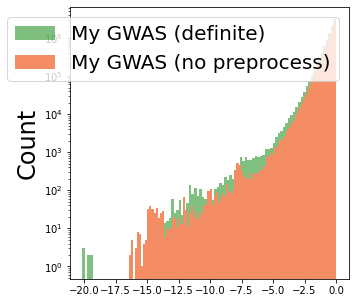

In [25]:
func_compare_pval(df_sumstat_mygwas_old_9m, df_sumstat_mygwas_new_fourway, "SNP",
                  "",
                  "P_MyGWAS_OLD_9M", "P_MyGWAS_NEW_FOURWAY",
                  "My GWAS (no preprocess)", "My GWAS (four-way)",
                  False, 10
                 )

func_compare_pval(df_sumstat_mygwas_old_9m, df_sumstat_mygwas_new_twoway, "SNP",
                  "",
                  "P_MyGWAS_OLD_9M", "P_MyGWAS_NEW_TWOWAY",
                  "My GWAS (no preprocess)", "My GWAS (two-way)",
                  False, 10
                 )

func_compare_pval(df_sumstat_mygwas_old_9m, df_sumstat_mygwas_new_definite, "SNP",
                  "",
                  "P_MyGWAS_OLD_9M", "P_MyGWAS_NEW_DEFINITE",
                  "My GWAS (no preprocess)", "My GWAS (definite)",
                  False, 10
                 )

Corr = 0.5567517273136412


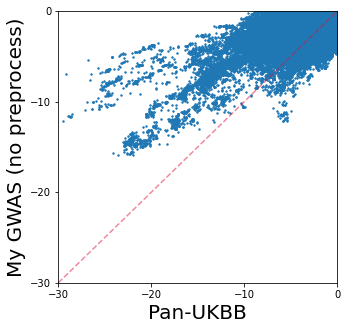

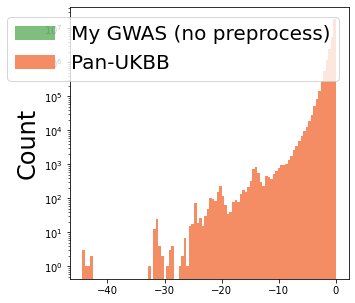

Corr = 0.4258956482200448


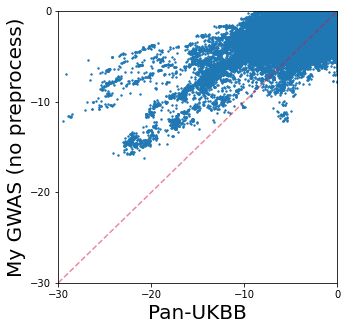

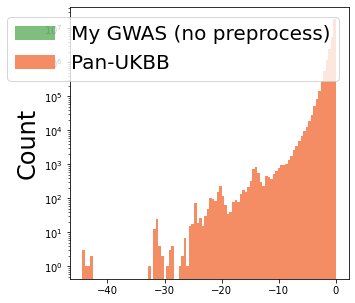

Corr = 0.9146618314471027


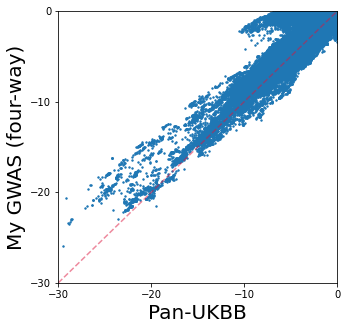

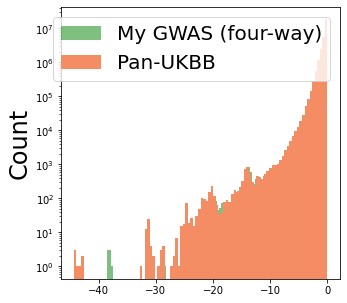

Corr = 0.808055367796656


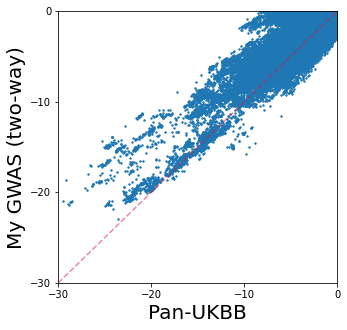

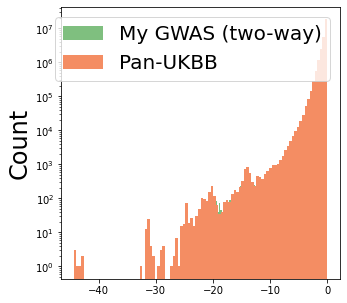

Corr = 0.7341762488656105


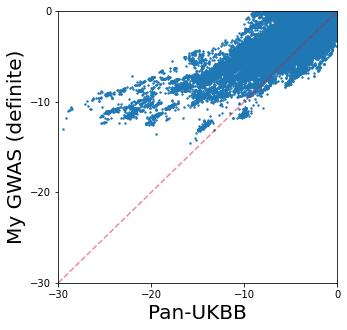

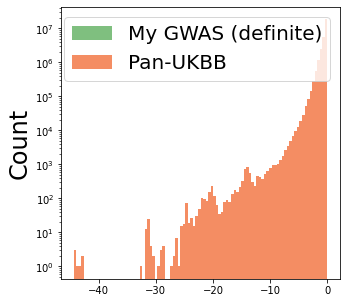

In [27]:
func_compare_pval(df_sumstat_panukbb, df_sumstat_mygwas_old_9m, "SNP",
                  "",
                  "P_PanUKBB", "P_MyGWAS_OLD_9M",
                  "Pan-UKBB", "My GWAS (no preprocess)",
                  False, 10
                 )

func_compare_pval(df_sumstat_panukbb, df_sumstat_mygwas_old_28m, "SNP",
                  "",
                  "P_PanUKBB", "P_MyGWAS_OLD_28M",
                  "Pan-UKBB", "My GWAS (no preprocess)",
                  False, 10
                 )

func_compare_pval(df_sumstat_panukbb, df_sumstat_mygwas_new_fourway, "SNP",
                  "",
                  "P_PanUKBB", "P_MyGWAS_NEW_FOURWAY",
                  "Pan-UKBB", "My GWAS (four-way)",
                  False, 10
                 )

func_compare_pval(df_sumstat_panukbb, df_sumstat_mygwas_new_twoway, "SNP",
                  "",
                  "P_PanUKBB", "P_MyGWAS_NEW_TWOWAY",
                  "Pan-UKBB", "My GWAS (two-way)",
                  False, 10
                 )

func_compare_pval(df_sumstat_panukbb, df_sumstat_mygwas_new_definite, "SNP",
                  "",
                  "P_PanUKBB", "P_MyGWAS_NEW_DEFINITE",
                  "Pan-UKBB", "My GWAS (definite)",
                  False, 10
                 )

Corr = 0.5567517273136411


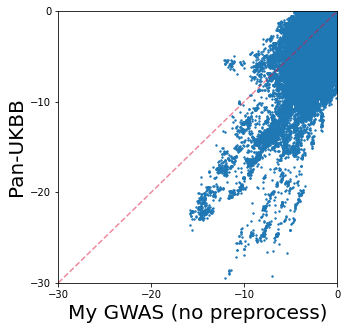

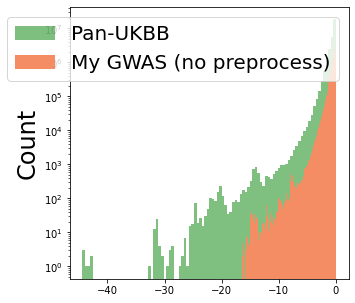

Corr = 0.4258956482200447


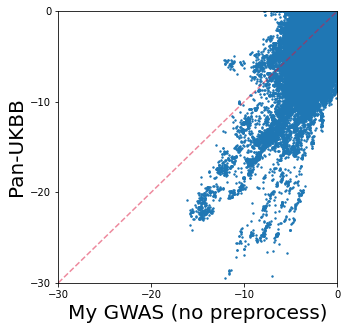

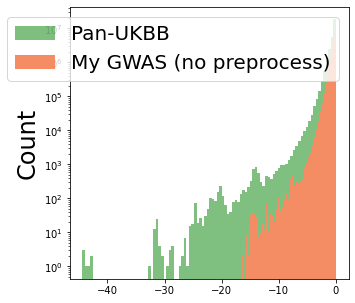

Corr = 0.9146618314471027


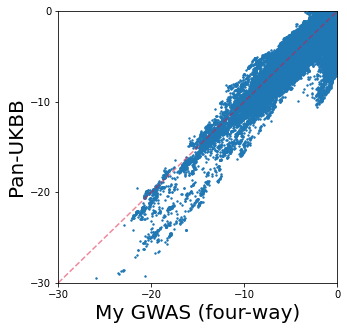

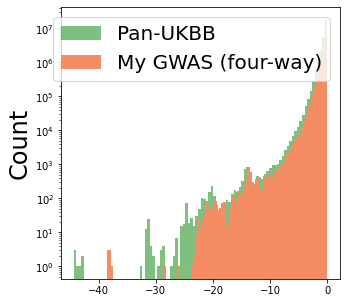

Corr = 0.808055367796656


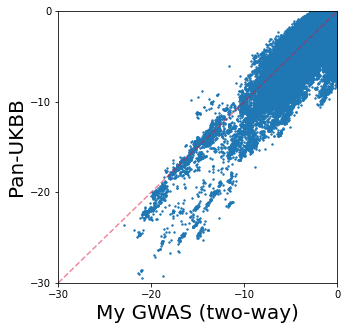

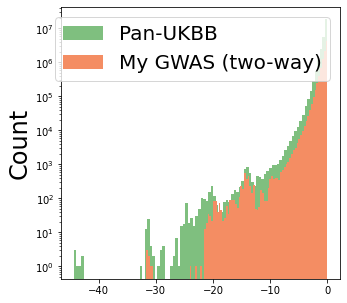

Corr = 0.7341762488656105


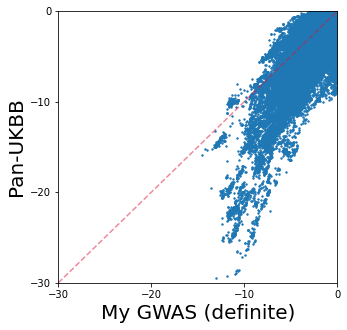

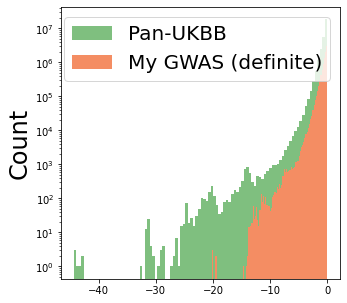

In [28]:
func_compare_pval(df_sumstat_mygwas_old_9m, df_sumstat_panukbb, "SNP",
                  "",
                  "P_MyGWAS_OLD_9M", "P_PanUKBB", 
                  "My GWAS (no preprocess)", "Pan-UKBB", 
                  False, 10
                 )

func_compare_pval(df_sumstat_mygwas_old_28m, df_sumstat_panukbb, "SNP",
                  "",
                  "P_MyGWAS_OLD_28M", "P_PanUKBB", 
                  "My GWAS (no preprocess)", "Pan-UKBB", 
                  False, 10
                 )

func_compare_pval(df_sumstat_mygwas_new_fourway, df_sumstat_panukbb, "SNP",
                  "",
                  "P_MyGWAS_NEW_FOURWAY", "P_PanUKBB", 
                  "My GWAS (four-way)", "Pan-UKBB", 
                  False, 10
                 )

func_compare_pval(df_sumstat_mygwas_new_twoway, df_sumstat_panukbb, "SNP",
                  "",
                  "P_MyGWAS_NEW_TWOWAY", "P_PanUKBB", 
                  "My GWAS (two-way)", "Pan-UKBB", 
                  False, 10
                 )

func_compare_pval(df_sumstat_mygwas_new_definite, df_sumstat_panukbb, "SNP",
                  "",
                  "P_MyGWAS_NEW_DEFINITE", "P_PanUKBB", 
                  "My GWAS (definite)", "Pan-UKBB", 
                  False, 10
                 )

### BMI

Corr = 0.9212063134229332


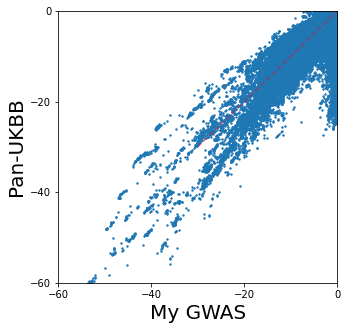

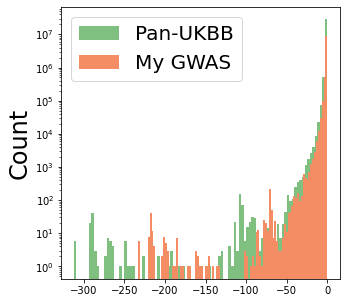

In [22]:
func_compare_pval(df_sumstat_mygwas_new_bmi, df_sumstat_panukbb_bmi, "SNP",
                  "",
                  "P_MyGWAS_NEW_BMI", "P_PanUKBB_BMI",
                  "My GWAS", "Pan-UKBB",
                  False, 20
                 )

# Process MAGMA results

## Add Pbonf, q-values, posi/nega annotation

In [4]:
list_files = []
for root, dirs, files in os.walk(DIR_MYGWAS_CURRENT):
    # Check if the target file exists in the current folder
    if "gene_pheno_pval_list_annotated.csv" in files:
        # Get the full path of the file
        file_source = os.path.join(root, "gene_pheno_pval_list_annotated.csv")
        file_out = os.path.join(root, "with_p_correction.csv")
        # Print the file path
        list_files.append([file_source, file_out])

list_files = sorted(list_files)
print(len(list_files), "Files are found")
list_files

25 Files are found


[['analysis\\specific\\analysis_20230605_01_gwas\\1180-0.0_Chronotype_definite_small\\magma\\gene_pheno_pval_list_annotated.csv',
  'analysis\\specific\\analysis_20230605_01_gwas\\1180-0.0_Chronotype_definite_small\\magma\\with_p_correction.csv'],
 ['analysis\\specific\\analysis_20230605_01_gwas\\1180-0.0_Chronotype_fourway_small\\magma\\gene_pheno_pval_list_annotated.csv',
  'analysis\\specific\\analysis_20230605_01_gwas\\1180-0.0_Chronotype_fourway_small\\magma\\with_p_correction.csv'],
 ['analysis\\specific\\analysis_20230605_01_gwas\\1180-0.0_Chronotype_twoway_small\\magma\\gene_pheno_pval_list_annotated.csv',
  'analysis\\specific\\analysis_20230605_01_gwas\\1180-0.0_Chronotype_twoway_small\\magma\\with_p_correction.csv'],
 ['analysis\\specific\\analysis_20230605_01_gwas\\21001-0.0_BMI_small\\magma\\gene_pheno_pval_list_annotated.csv',
  'analysis\\specific\\analysis_20230605_01_gwas\\21001-0.0_BMI_small\\magma\\with_p_correction.csv'],
 ['analysis\\specific\\analysis_20230605_01_

In [5]:
list_sets_genes = []

for list_IO in list_files:
    print()
    func_process(list_IO[0], list_IO[1])
    set_genes_all, set_genes_positive = func_list_genes(list_IO[1])
    list_sets_genes.append([list_IO[1], set_genes_all, set_genes_positive])


Processing: analysis\specific\analysis_20230605_01_gwas\1180-0.0_Chronotype_definite_small\magma\gene_pheno_pval_list_annotated.csv
All = 17995 genes, positive = 57 genes

Processing: analysis\specific\analysis_20230605_01_gwas\1180-0.0_Chronotype_fourway_small\magma\gene_pheno_pval_list_annotated.csv
All = 17995 genes, positive = 173 genes

Processing: analysis\specific\analysis_20230605_01_gwas\1180-0.0_Chronotype_twoway_small\magma\gene_pheno_pval_list_annotated.csv
All = 17995 genes, positive = 119 genes

Processing: analysis\specific\analysis_20230605_01_gwas\21001-0.0_BMI_small\magma\gene_pheno_pval_list_annotated.csv
All = 17995 genes, positive = 1003 genes

Processing: analysis\specific\analysis_20230605_01_gwas\ukb671006_28475_group_eid_old_1\magma\gene_pheno_pval_list_annotated.csv
All = 17995 genes, positive = 0 genes

Processing: analysis\specific\analysis_20230605_01_gwas\ukb671006_28475_group_eid_old_2a\magma\gene_pheno_pval_list_annotated.csv
All = 17995 genes, positive

## List up the genes

In [9]:
print("My GWAS (new)")
set_genes_all_mygwas, set_genes_positive_mygwas = \
func_list_genes(FILE_ANNOTATED_MYGWAS_NEW_FOURWAY)
print()

print("My GWAS (old)")
set_genes_all_mygwas_old, set_genes_positive_mygwas_old = \
func_list_genes(FILE_ANNOTATED_MYGWAS_OLD_9M)
print()

print("Pan-UKBB")

set_genes_all_panukbb, set_genes_positive_panukbb = \
func_list_genes(FILE_MAGMA_PANUKBB_CHRONOTYPE, col_gene="NAME")

My GWAS (new)
All = 17995 genes, positive = 173 genes

My GWAS (old)
All = 17995 genes, positive = 36 genes

Pan-UKBB
All = 19427 genes, positive = 270 genes


## Draw Venn diagrams

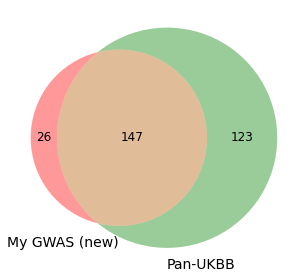

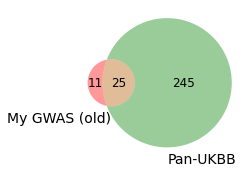

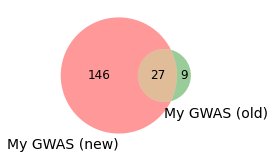

In [11]:
func_venn2(set_genes_positive_mygwas, set_genes_positive_panukbb, ["My GWAS (new)", "Pan-UKBB"])
func_venn2(set_genes_positive_mygwas_old, set_genes_positive_panukbb, ["My GWAS (old)", "Pan-UKBB"])
func_venn2(set_genes_positive_mygwas, set_genes_positive_mygwas_old, ["My GWAS (new)", "My GWAS (old)"])

In [12]:
print("Only in old", set_genes_positive_mygwas_old - set_genes_positive_mygwas)
print()

print("Only in new", set_genes_positive_mygwas - set_genes_positive_mygwas_old)

Only in old {'RGL1', 'PTPN21', 'KIF21A', 'ZMYND10', 'TTC8', 'PC', 'RBM14', 'CTSF', 'SPATA7'}

Only in new {'SEMA3F', 'MEF2C', 'AKAP5', 'TMEM108', 'PMPCB', 'CAMKV', 'PACS1', 'GNAI3', 'DGKG', 'TMEM161B', 'PHACTR1', 'EPC2', 'UBXN2A', 'PER1', 'ECM1', 'HNRNPD', 'ILKAP', 'KBTBD4', 'ZFP91', 'ZCCHC7', 'PMFBP1', 'NDUFS3', 'FIGNL1', 'ARHGAP15', 'GRB10', 'PREPL', 'CNIH2', 'SCAF11', 'DYNLL1', 'MRPS21', 'CUX1', 'CHAF1A', 'CALB2', 'RASA1', 'HP', 'OR5B2', 'HTR6', 'TES', 'LRRTM4', 'UBXN6', 'SLC18A2', 'PLCL1', 'PRR7', 'PRPF3', 'GPC6', 'NEBL', 'RBM5', 'MACROD2', 'PMPCA', 'HCRTR2', 'NMUR2', 'AXDND1', 'UNC5D', 'POU2F2', 'HPR', 'DAB1', 'PER2', 'INPP5E', 'PDE1C', 'TRAF3IP1', 'ST18', 'EXD3', 'SEC11C', 'FBXO5', 'FBXL17', 'DDC', 'TFEC', 'HYAL2', 'TARS2', 'MST1R', 'KLHL29', 'C1orf54', 'CRY1', 'AP2B1', 'DHODH', 'CBX5', 'EGFL8', 'ORAI2', 'VAMP2', 'ZNF365', 'RNF10', 'ALG10', 'SEC16A', 'PNMAL2', 'FAM132B', 'GRK6', 'ZNF821', 'SLC38A3', 'PTPMT1', 'LOC101927254', 'MYCBP2', 'ZBTB25', 'FAM83B', 'DENND1A', 'UTS2', 'DBN1'

## Compare P-values

In [22]:
df_genebased_mygwas = pl.read_csv(FILE_ANNOTATED_MYGWAS_NEW_FOURWAY, separator=",")
df_genebased_mygwas_old = pl.read_csv(FILE_ANNOTATED_MYGWAS_OLD_9M, separator=",")
df_genebased_panukbb = pl.read_csv(FILE_MAGMA_PANUKBB_CHRONOTYPE, separator=",")

# Extract columns "NAME" and "P"
df_genebased_mygwas = (df_genebased_mygwas
                       .select(["Gene", "P_log10"])
                       .rename({"P_log10": "Log10P_mygwas", "Gene": "NAME"})
                      )

df_genebased_mygwas_old = (df_genebased_mygwas_old
                           .select(["Gene", "P_log10"])
                           .rename({"P_log10": "Log10P_mygwas_old", "Gene": "NAME"})
                          )

df_genebased_panukbb = (df_genebased_panukbb
                        .select(["NAME", "P_log10"])
                        .rename({"P_log10": "Log10P_panukbb"})
                       )

In [23]:
print(df_genebased_mygwas.head)
print(df_genebased_mygwas_old.head)
print(df_genebased_panukbb.head)

<bound method DataFrame.head of shape: (17_995, 2)
┌─────────┬───────────────┐
│ NAME    ┆ Log10P_mygwas │
│ ---     ┆ ---           │
│ str     ┆ f64           │
╞═════════╪═══════════════╡
│ FBXL3   ┆ -15.556643    │
│ LRRTM4  ┆ -15.292029    │
│ CLN5    ┆ -14.976871    │
│ RBFOX1  ┆ -14.542921    │
│ …       ┆ …             │
│ ELANE   ┆ -0.000187     │
│ GRHL1   ┆ -0.000104     │
│ KANK1   ┆ -0.000039     │
│ PPP1R17 ┆ -0.000017     │
└─────────┴───────────────┘>
<bound method DataFrame.head of shape: (17_995, 2)
┌──────────┬───────────────────┐
│ NAME     ┆ Log10P_mygwas_old │
│ ---      ┆ ---               │
│ str      ┆ f64               │
╞══════════╪═══════════════════╡
│ ALG10B   ┆ -14.71155         │
│ RGS16    ┆ -14.632364        │
│ CPNE8    ┆ -13.460435        │
│ C11orf80 ┆ -11.183089        │
│ …        ┆ …                 │
│ G3BP1    ┆ -0.000161         │
│ SAG      ┆ -0.000152         │
│ ANKRD26  ┆ -0.00003          │
│ SCRG1    ┆ -0.000004         │
└──────────┴───

Corr = 0.9266877399756175


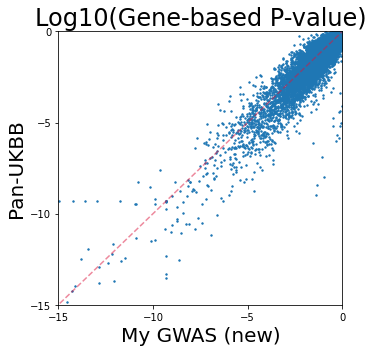

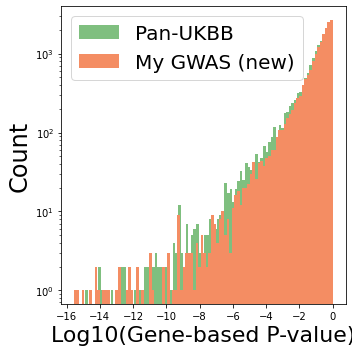

Corr = 0.5994870867176094


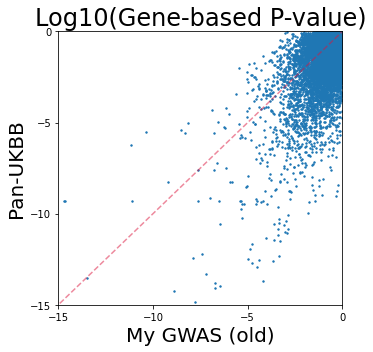

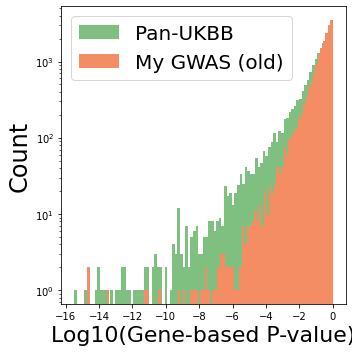

Corr = 0.6513518050923597


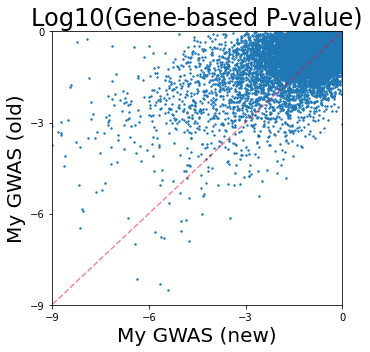

In [ ]:
func_compare_pval(df_genebased_mygwas, df_genebased_panukbb, "NAME",
                  "Log10(Gene-based P-value)",
                  "Log10P_mygwas", "Log10P_panukbb",
                  "My GWAS (new)", "Pan-UKBB",
                  True, 5
                 )

func_compare_pval(df_genebased_mygwas_old, df_genebased_panukbb, "NAME",
                  "Log10(Gene-based P-value)",
                  "Log10P_mygwas_old", "Log10P_panukbb",
                  "My GWAS (old)", "Pan-UKBB",
                  True, 5
                 )

func_compare_pval(df_genebased_mygwas, df_genebased_mygwas_old, "NAME",
                  "Log10(Gene-based P-value)",
                  "Log10P_mygwas", "Log10P_mygwas_old",
                  "My GWAS (new)", "My GWAS (old)",
                  True, 3
                 )